In [ ]:
https://www.researchgate.net/publication/320339964_Naive_Bayes_Switching_Linear_Dynamical_System_A_model_for_dynamic_system_modelling_classification_and_information_fusion

https://www.sciencedirect.com/science/article/pii/S0001457520306680dd

In [20]:
# Load data
#Load packages
import numpy as np
import pandas as pd   # We import Pandas!
from matplotlib import pyplot as plt
from sklearn import linear_model
import torch


df_acc = pd.read_csv("data/bym_nyc_study.csv")  
df_census = pd.read_csv("data/nyc_census_tracts.csv")  


# Data sources:
# https://data.mendeley.com/datasets/b5r4yztghx/2

# project (Rico)
# https://www.sciencedirect.com/science/article/abs/pii/S1877584518301175
# https://mc-stan.org/users/documentation/case-studies/icar_stan.html


# Artikel
# https://www1.nyc.gov/assets/doh/downloads/pdf/epi/databrief86.pdf

### Date preprocessing

In [27]:

df_merged = df_acc.merge(df_census, left_on='census_tract', right_on='CensusTract')
df_merged.pop("CensusTract")

Index(['census_tract', 'ped_injury_5to18', 'youth_pop_5to18',
       'commute_priv_vehicle', 'med_hhincome', 'avg_ann_daily_traffic',
       'fragment_index', 'County', 'Borough', 'TotalPop', 'Men', 'Women',
       'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Citizen', 'Income',
       'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty',
       'ChildPoverty', 'Professional', 'Service', 'Office', 'Construction',
       'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment'],
      dtype='object')

## Data viz

In [28]:
attributes = ['ped_injury_5to18', 'youth_pop_5to18','commute_priv_vehicle', 'med_hhincome', 'avg_ann_daily_traffic','fragment_index']
df_viz = df_merged[df_merged.columns[df_merged.columns.isin(attributes)]]

In [34]:
df_merged

,census_tract,ped_injury_5to18,youth_pop_5to18,commute_priv_vehicle,med_hhincome,avg_ann_daily_traffic,fragment_index,County,Borough,TotalPop,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,36005000200,9,894,0.634634,74837,8682.0,-3.061385,Bronx,Bronx,5403,...,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7
1,36005000400,12,1158,0.494977,77991,16917.0,-2.915361,Bronx,Bronx,5915,...,1.4,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5
2,36005001600,28,1120,0.422405,32354,22712.0,-0.227456,Bronx,Bronx,5879,...,8.6,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7
3,36005001900,14,281,0.199795,34635,124767.0,3.029461,Bronx,Bronx,2591,...,3.0,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2
4,36005002000,21,1998,0.286795,23423,10219.0,0.165237,Bronx,Bronx,8516,...,4.3,1.0,0.0,46.0,2508,71.0,21.3,7.7,0.0,17.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2090,36085030301,11,817,0.636708,59625,49278.0,-2.329049,Richmond,Staten Island,4895,...,1.2,1.4,1.4,47.4,2298,78.4,18.7,2.6,0.3,7.4
2091,36085030302,21,1319,0.593896,80887,41491.0,-3.616563,Richmond,Staten Island,6279,...,0.9,0.0,1.3,46.6,2668,74.4,22.5,3.2,0.0,6.2
2092,36085031901,5,831,0.544980,27031,10098.0,-0.170120,Richmond,Staten Island,2550,...,9.5,0.0,0.0,38.2,710,73.8,21.8,4.4,0.0,13.8
2093,36085031902,8,1138,0.549141,31750,11931.0,0.284138,Richmond,Staten Island,4611,...,0.5,0.0,2.7,40.9,1308,84.7,12.6,2.7,0.0,9.4


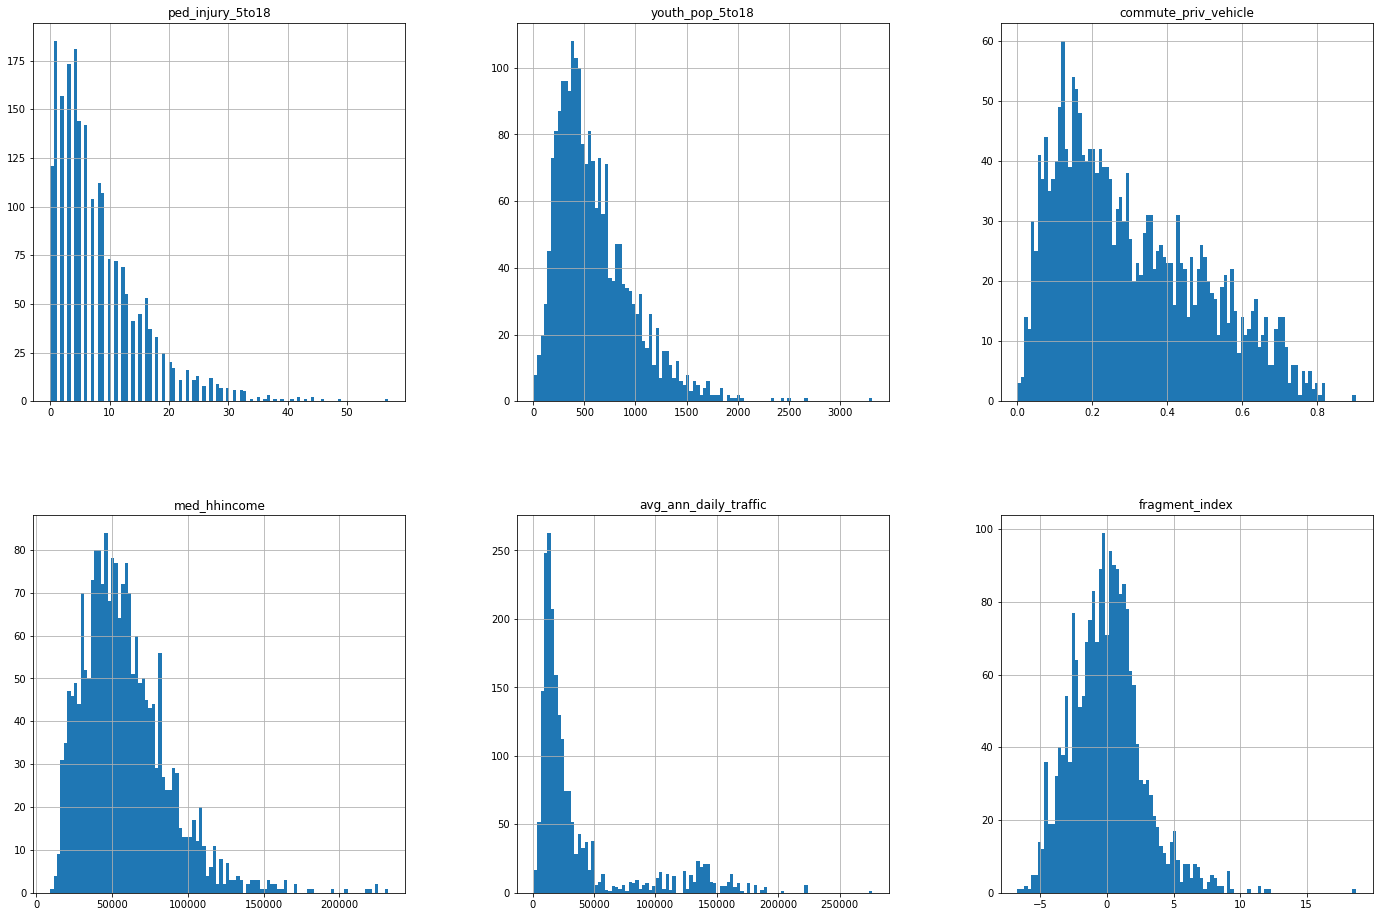

In [30]:
fig, axes = plt.subplots(len(df_viz.columns)//3, 3, figsize=(24, 16))

i = 0
for triaxis in axes:
    for axis in triaxis:
        df_viz.hist(column = df_viz.columns[i], bins = 100, ax=axis)
        i = i+1

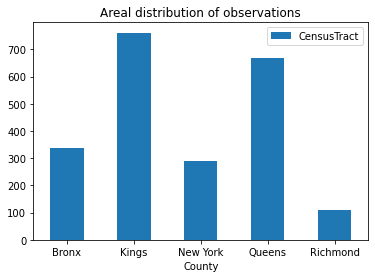

In [33]:
fig, ax = plt.subplots(1,1)
df_census.groupby("County").count().plot.bar(y="CensusTract", ax=ax, rot=0)
plt.title("Areal distribution of observations")
plt.show()